In [1]:
#dependencies
#data processing
import numpy as np 
import pandas as pd 

# visualizaion
import matplotlib.pyplot as plt 
import seaborn as sns 

# display graphs inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('titanic_data/train.csv')
test_df = pd.read_csv('titanic_data/test.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### Missing Values from the train dataset

* Age,Cabin amd Embarked are the columns for missing values. We will work on imputing missing field data

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* We see the average Age of the passengers is 29.69

### Feature Engineering

* Name - categorize passengers through the titles in the name to see is there is any relationship between name and survival

In [5]:
#grab the tittle from passenger name
def title(name):
    start = name.find(',')
    end = name.find('.')
    return name[start+2:end]


df['Title'] = df.Name.map(title)

#show title count by sex
pd.crosstab(df.Sex,df.Title)

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [6]:
# Titles with very low cell counts to be combined to "rare" level

rare_title = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
df.loc[:,"Title"] = df["Title"].map(lambda x: x if x not in rare_title else 'Rare_Title')
df.loc[df.Title == 'Mlle',"Title"] = 'Miss'
df.loc[df.Title == 'Ms',"Title"] = 'Miss'
df.loc[df.Title == 'Mme',"Title"] = 'Mrs'

# Show title counts by sex again
pd.crosstab(df.Sex,df.Title)

Title,Master,Miss,Mr,Mrs,Rare_Title
Sex,,,,,
female,0,185,0,126,3
male,40,0,517,0,20


In [7]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr


### SibSp and Parch:

* SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. I will create it below and also a feature that shows if someone is not alone.

In [8]:
data = [df, test_df]

for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

In [9]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,relatives,not_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,1,0


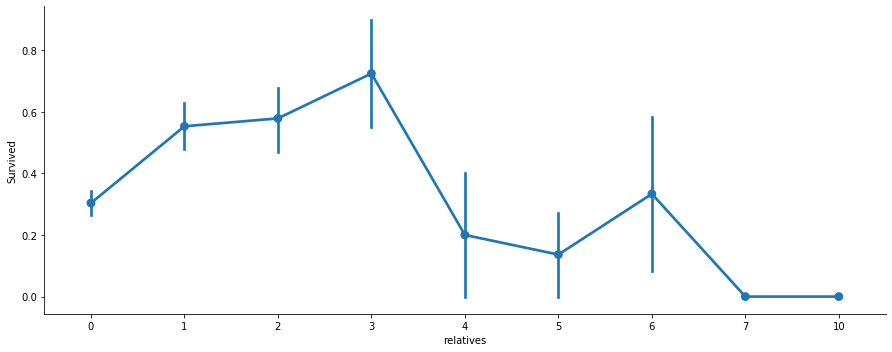

In [10]:
axes = sns.factorplot('relatives','Survived', 
                      data=df, aspect = 2.5, )

* Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

* We can see that there’s a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let’s create a discretized family size variable.

* The mosaic plot shows that we preserve our rule that there’s a survival penalty among singletons and large families, but a benefit for passengers in small families. I want to do something further with our age variable, but 263 rows have missing age values, so we will have to wait until after we address missingness.

### PClass

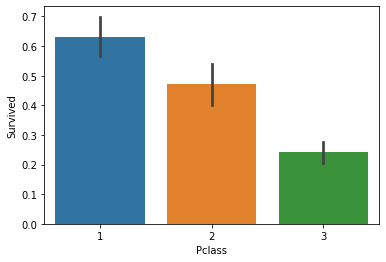

In [11]:
sns.barplot(x='Pclass', y='Survived', data=df)

* Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.

### Missing Values

* Cabin (687), 
* Embarked (2) and 
* Age (177)

#### Embarked - 
* Passengers with passengerId 62 and 830 are missing Embarkment
* Known information - passenger class and fare. We see that they paid 80 and their classes are 1. So from where did they embark?

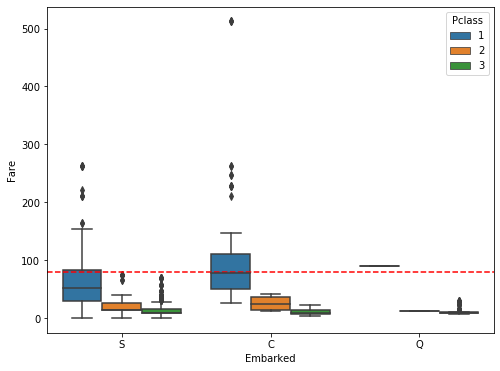

In [12]:
# Get rid of our missing passenger IDs

embark_fare = df[(df.PassengerId!=62) & (df.PassengerId != 830)]
fig,ax = plt.subplots(figsize=(8,6))
b = sns.boxplot(x='Embarked',y='Fare',hue='Pclass',data=df)
line = ax.axhline(y=80, color='r', linestyle='--')


* The median fare for a first class passenger departing from Charbourg (‘C’) coincides nicely with the $80 paid by our embarkment-deficient passengers. I think we can safely replace the NA values with ‘C’.

In [13]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
df.loc[[62,829],'Embarked'] = 'C'

#### Age - will be imputed by using SimpleImputer. It is a scikit-learn class which is helpful in handling the missing data in the predictive model dataset.

In [14]:
from sklearn.impute import SimpleImputer
import numpy as np
from matplotlib import pyplot as plt 

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df['Age'].values.reshape(-1, 1))
df['Age'] = imp_mean.transform(df['Age'].values.reshape(-1, 1))

#### Cabin - for categorical variable Deck I will populate it with the most frequent item in the column.

In [15]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype('int64')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     890 non-null    object 
 12  Title        891 non-null    object 
 13  relatives    891 non-null    int64  
 14  not_alone    891 non-null    int32  
 15  Deck         891 non-null    int64  
dtypes: float64(2), int32(1), int64(7), object(6)
memory usage: 108.0+ KB


### Converting Features

* convert Age and Fare into int
* categorical features: Title,Sex,Ticket and Embarked

In [17]:
df['Age'] = df['Age'].astype('int64')

In [18]:
df['Fare'] = df['Fare'].astype('int64')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Name         891 non-null    object
 4   Sex          891 non-null    object
 5   Age          891 non-null    int64 
 6   SibSp        891 non-null    int64 
 7   Parch        891 non-null    int64 
 8   Ticket       891 non-null    object
 9   Fare         891 non-null    int64 
 10  Cabin        891 non-null    object
 11  Embarked     890 non-null    object
 12  Title        891 non-null    object
 13  relatives    891 non-null    int64 
 14  not_alone    891 non-null    int32 
 15  Deck         891 non-null    int64 
dtypes: int32(1), int64(9), object(6)
memory usage: 108.0+ KB


#### Titles

In [20]:
data = [df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare_Title": 5}

for d in data:
    d['Title'] = d['Title'].map(titles)

#### Gender

In [21]:
genders = {"male": 0, "female": 1}
data = [df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Ticket

In [22]:
df['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [23]:
df = df.drop(['Ticket'], axis=1)

#### Embarked

In [24]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

df['Embarked'] = df['Embarked'].fillna(0)
df['Embarked'] = df['Embarked'].astype('int64')

#### Age

In [25]:
data = [df]
for dataset in data:
    
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

df['Age'].value_counts()

4    303
6    148
3    106
5    103
2     92
1     71
0     68
Name: Age, dtype: int64

#### Fare:
* For the ‘Fare’ feature, we need to do the same as with the ‘Age’ feature. But it isn’t that easy, because if we cut the range of the fare values into a few equally big categories, 80% of the values would fall into the first category. Fortunately, we can use sklearn “qcut()” function, that we can use to see, how we can form the categories.

In [26]:
data = [df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5

df['Fare'].value_counts()

0    241
2    223
1    216
3    158
4     44
5      9
Name: Fare, dtype: int64

### Prediction

In [27]:
# dropping columns not needed
df = df.drop(['Name','Cabin','PassengerId'],axis=1)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,relatives,not_alone,Deck
0,0,3,0,2,1,0,0,0,1,1,0,8
1,1,1,1,5,1,0,3,1,3,1,0,3
2,1,3,1,3,0,0,0,0,2,0,1,8
3,1,1,1,5,1,0,3,0,3,1,0,3
4,0,3,0,5,0,0,1,0,1,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,3,0,0,1,0,5,0,1,8
887,1,1,1,2,0,0,2,0,2,0,1,2
888,0,3,1,4,1,2,2,0,2,3,0,8
889,1,1,0,3,0,0,2,1,1,0,1,3


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Survived   891 non-null    int64
 1   Pclass     891 non-null    int64
 2   Sex        891 non-null    int64
 3   Age        891 non-null    int64
 4   SibSp      891 non-null    int64
 5   Parch      891 non-null    int64
 6   Fare       891 non-null    int64
 7   Embarked   891 non-null    int64
 8   Title      891 non-null    int64
 9   relatives  891 non-null    int64
 10  not_alone  891 non-null    int32
 11  Deck       891 non-null    int64
dtypes: int32(1), int64(11)
memory usage: 80.2 KB


In [29]:
X = df.drop('Survived',axis=1)
y = df['Survived']

### Feature Selection

[0.1161783  0.28352545 0.12637594 0.04128962 0.02447462 0.09038174
 0.04801919 0.12169222 0.04435573 0.0165668  0.0871404 ]


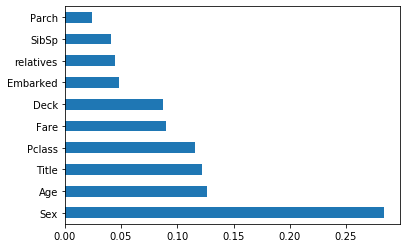

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)

#use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [31]:
# Set features on the basis of importance
X = df[feat_importances.index]
Y = df['Survived']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

# Create scaler object
X_scaler = MinMaxScaler().fit(X_train)

# Scale training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [36]:
# Support vector machine linear classifier

from sklearn.svm import SVC 

model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [37]:
# Model Accuracy
print(f"Training Data Score: {model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model.score(X_test_scaled, y_test)}")

Training Data Score: 0.7859281437125748
Testing Data Score: 0.7668161434977578


In [38]:
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV model
param_grid = [{'C':[1, 5, 10, 50], 'kernel':['linear']},
             {'C':[1, 5, 10, 50], 'kernel':['rbf'], 'gamma': [0.0001, 0.0005, 0.001, 0.005]}]

grid = GridSearchCV(model, param_grid, verbose=3)

In [39]:
# Train the new model with GridSearch
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.754, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.843, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.746, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.782, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.827, total=   0.0s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.754, total=   0.0s
[CV] C=5, kernel=linear ..............................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=50, kernel=linear .............................................
[CV] ................. C=50, kernel=linear, score=0.754, total=   0.0s
[CV] C=50, kernel=linear .............................................
[CV] ................. C=50, kernel=linear, score=0.843, total=   0.0s
[CV] C=50, kernel=linear .............................................
[CV] ................. C=50, kernel=linear, score=0.746, total=   0.0s
[CV] C=50, kernel=linear .............................................
[CV] ................. C=50, kernel=linear, score=0.789, total=   0.0s
[CV] C=50, kernel=linear .............................................
[CV] ................. C=50, kernel=linear, score=0.850, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.619, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.619, total=   0.0s
[CV] 

[CV] ....... C=50, gamma=0.001, kernel=rbf, score=0.761, total=   0.0s
[CV] C=50, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=50, gamma=0.001, kernel=rbf, score=0.851, total=   0.0s
[CV] C=50, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=50, gamma=0.001, kernel=rbf, score=0.739, total=   0.0s
[CV] C=50, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=50, gamma=0.001, kernel=rbf, score=0.767, total=   0.0s
[CV] C=50, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=50, gamma=0.001, kernel=rbf, score=0.820, total=   0.0s
[CV] C=50, gamma=0.005, kernel=rbf ...................................
[CV] ....... C=50, gamma=0.005, kernel=rbf, score=0.761, total=   0.0s
[CV] C=50, gamma=0.005, kernel=rbf ...................................
[CV] ....... C=50, gamma=0.005, kernel=rbf, score=0.821, total=   0.0s
[CV] C=50, gamma=0.005, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid=[{'C': [1, 5, 10, 50], 'kernel': ['linear']},
                         {'C': [1, 5, 10, 50],
                          'gamma': [0.0001, 0.0005, 0.001, 0.005],
                          'kernel': ['rbf']}],
             verbose=3)

In [40]:
print(grid.best_params_)
print("Best Score: ", grid.best_score_)

{'C': 50, 'kernel': 'linear'}
Best Score:  0.7964762652900909
